In [59]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
import glob

import sys
sys.path.append('../scripts')
import util
import ip_routines as ip

verbose = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
def calulateDeltaRatio(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    delta_img = ip.deltaImage(bg_img, fg_img, 5)
    #blue_chan_mean = np.abs(np.mean(blue_chan))
    hist = np.bincount(delta_img.ravel(),minlength=256)
    ratio = float(hist[-1])/float(hist[0])
    return hist[0], hist[1], ratio

In [61]:
#image_folder_lst = ['../projects/contact_front/MR_NewCam']
image_folder_lst = ['../projects/contact_front/MR_NewCam/startAtFirstCircle']
#image_folder_lst = ['../projects/contact_front/MR_NewCam/transitionSet']
#image_folder_lst = ['../projects/contact_front/MR_NewCam/testSet']

file_spec = '2015-08-04_DFI28-*.png'
glob_spec = "%s/%s" % (image_folder_lst[0], file_spec)
eng = util.Image_Engine(glob_spec, is_glob=True)

delay_s=0.01
do_plot=False  # must be False for running in notebook
verbose=True

ret, stats = ip.processImages_CumSumDiff(eng, delay_s, do_plot, verbose)

if len(stats['areas']) > 0:
    plt.figure(figsize=(10*2,5))
    plt.plot(stats['areas'])
    plt.title('Contact Areas')
    
if len(stats['deltas']) > 0:
    plt.figure(figsize=(10*2,5))
    plt.plot(stats['deltas'][1:]) # skip the first data pt since it includes non-active area 
    plt.title('Delta Area')


Image Engine initialized with  ../projects/contact_front/MR_NewCam/startAtFirstCircle/2015-08-04_DFI28-*.png
 Total images:  426


TypeError: processImages_CumSumDiff() takes exactly 5 arguments (4 given)

TypeError: 'numpy.float64' object is not callable

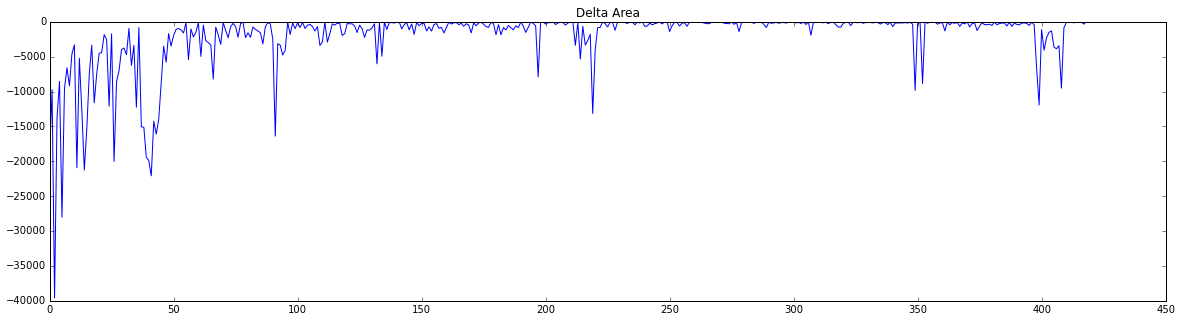

In [56]:
d = stats['deltas']
plt.figure(figsize=(10*2,5))
plt.plot(stats['deltas'][1:])
plt.title('Delta Area')
plt.show()
np.min(d)


In [62]:
image_folder_lst = ['../projects/contact_front/MR_NewCam']
img_lst = util.Image_List(image_folder_lst, '2015-08-04_DFI28-*.png', doSort=True, color=True)

print "Read %d images from %s" % (img_lst.cnt(), image_folder_lst[0])

Read 20 images from ../projects/contact_front/MR_NewCam


Count non-zero before:  0
Count non-zero after :  50204
Count non-zero before:  50204
Count non-zero after :  380879


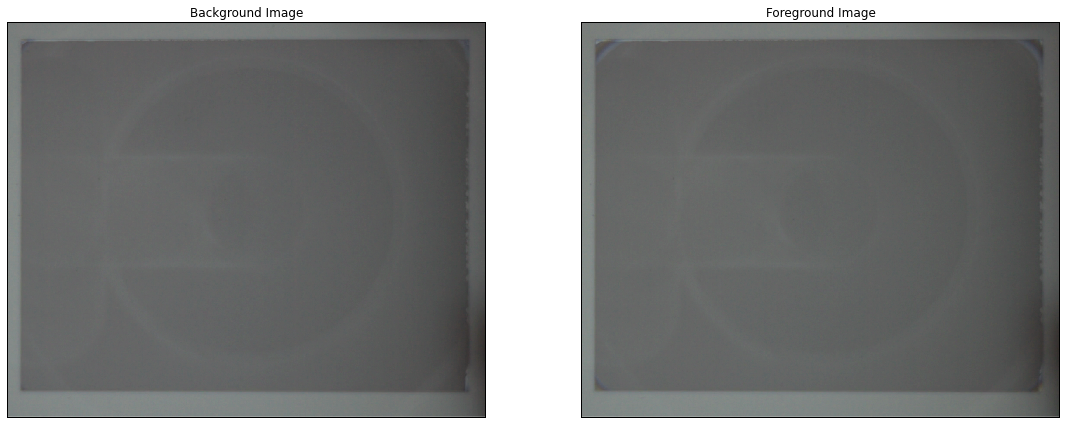

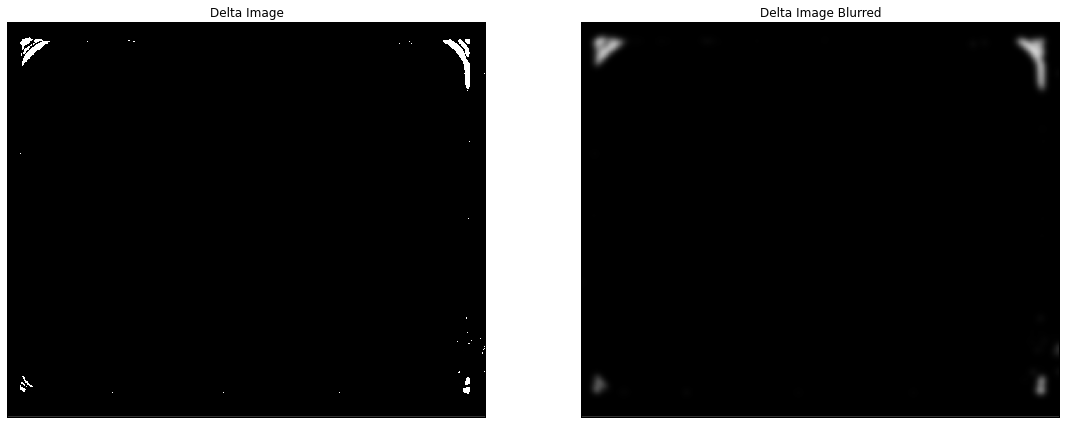

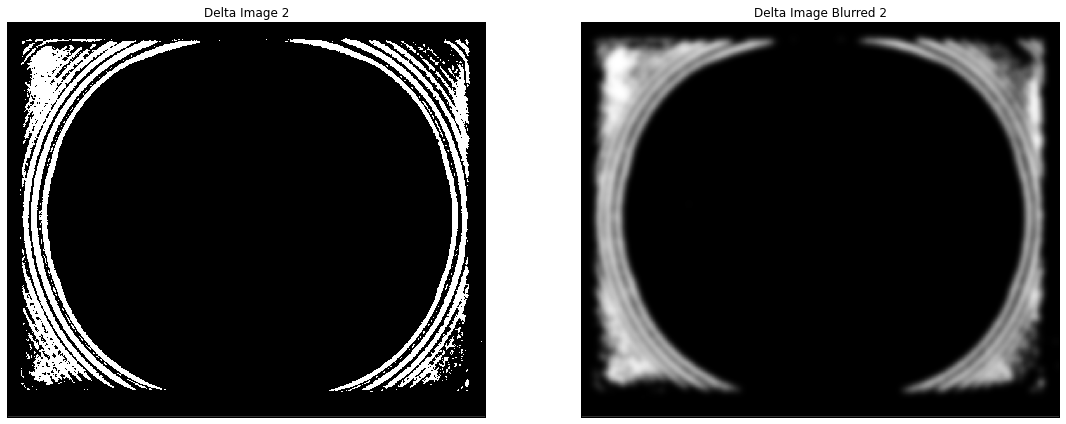

In [44]:
plot_lst = []
fg_num = 1
bg_img = img_lst.images[fg_num-1].copy()
fg_img = img_lst.images[fg_num].copy()

plot_lst.append( (bg_img, 'Background Image'))
plot_lst.append( (fg_img, 'Foreground Image'))

cum_img = np.zeros(fg_img.shape[:2], np.bool)

#delta_img = cv2.absdiff(bg_img, fg_img)
delta_img = ip.deltaImage(bg_img, fg_img, thresh_val=5)
plot_lst.append( (delta_img, 'Delta Image'))

delta_img_blurred = cv2.GaussianBlur(delta_img, (55, 55), 0)
plot_lst.append( (delta_img_blurred, 'Delta Image Blurred'))

print "Count non-zero before: ", np.count_nonzero(cum_img)
cum_img = np.logical_or(cum_img, delta_img_blurred)
print "Count non-zero after : ", np.count_nonzero(cum_img)

bg_img = fg_img
fg_img = img_lst.images[fg_num+1].copy()

delta_img = ip.deltaImage(bg_img, fg_img, thresh_val=5)
plot_lst.append( (delta_img, 'Delta Image 2'))

delta_img_blurred = cv2.GaussianBlur(delta_img, (55, 55), 0)
plot_lst.append( (delta_img_blurred, 'Delta Image Blurred 2'))

print "Count non-zero before: ", np.count_nonzero(cum_img)
cum_img = np.logical_or(cum_img, delta_img_blurred)
print "Count non-zero after : ", np.count_nonzero(cum_img)

util.plot_imgs(plot_lst, color=False, max_cols = 2)

blacks: 1248310, whites: 0, ratio: 0.00470


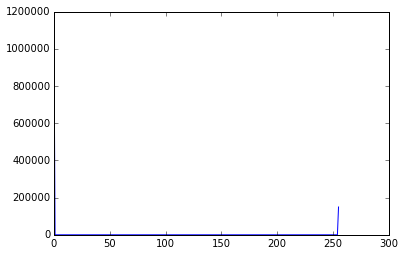

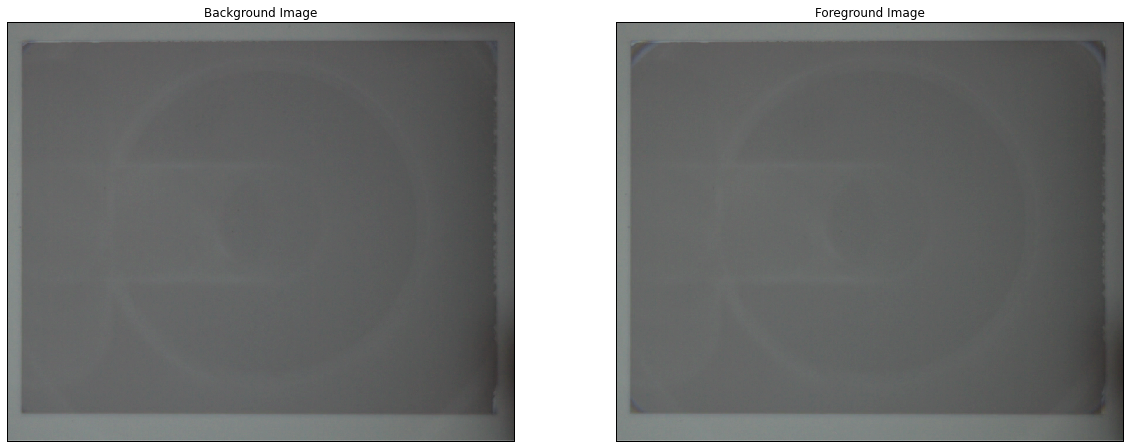

In [73]:
plot_lst = []
fg_num = 1
bg_img = img_lst.images[fg_num-1].copy()
fg_img = img_lst.images[fg_num].copy()

plot_lst.append( (bg_img, 'Background Image'))
plot_lst.append( (fg_img, 'Foreground Image'))

hist = np.bincount(delta_img.ravel(),minlength=256)

plt.plot( hist)

#rects1 = ax.bar(ind, menMeans, width, color='r', yerr=menStd)

blacks = hist[0]
whites = hist[-1]
ratio = float(whites)/float(blacks)

blacks, whites, ratio = calulateDeltaRatio(bg_img, fg_img)
print ("blacks: %d, whites: %d, ratio: %.5f" % (blacks, whites, ratio))

util.plot_imgs(plot_lst, color=False, max_cols = 2)

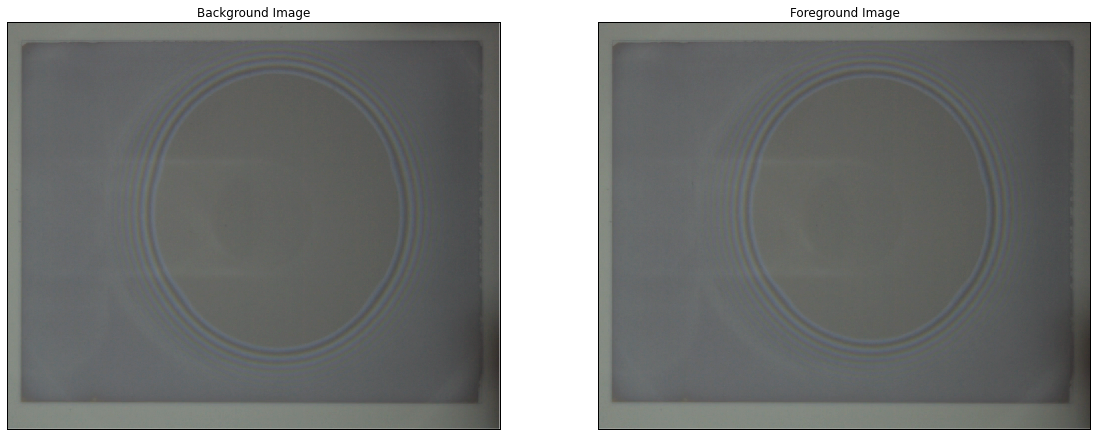

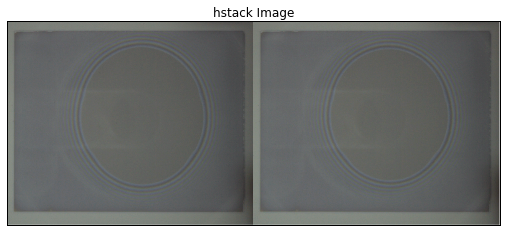

In [65]:
plot_lst = []
fg_num = 8
bg_img = img_lst.images[fg_num-1].copy()
fg_img = img_lst.images[fg_num].copy()

img = np.hstack((bg_img, fg_img))

plot_lst.append( (bg_img, 'Background Image'))
plot_lst.append( (fg_img, 'Foreground Image'))
plot_lst.append( (img, 'hstack Image'))

util.plot_imgs(plot_lst, color=False, max_cols = 2)

In [ ]:
video_file_path = '/data/projects/contact_front/MR_NewCam/2015-08-04_DFI28.mp4'

cap = cv2.VideoCapture(video_file_path)

cnt = 0
prev_img = None

ratios = []
while(cap.isOpened()):
    ret, new_img = cap.read()
    cnt += 1
    
    if ret:
        if prev_img == None:
            prev_img = new_img
            continue

        blacks, whites, ratio = calulateDeltaRatio(prev_img, new_img)
        ratios.append(ratio)

print "Done processing ", cnt, " images..."
print "Found ", len(ratios), " data pts:"
plt.figure(figsize=(10*2,5))
plt.plot(ratios, color='b')
plt.title('RGB mean values from center ROI')

### 